<a href="https://colab.research.google.com/github/tomiambro/ap_automatico/blob/tps-tomi/tp2pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, tensor, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

## Configuracion

Seteamos el dispositivo

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Cambiar el path para que coincida con el drive personal

In [4]:
root_path = 'gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset'  #change dir to your project folder

## Cargamos y exploramos el dataset

Levantamos la ruta de imagenes dentro de un objeto Path para poder iterar y leerlas

In [5]:
from pathlib import Path
imgs_path = Path(f'{root_path}/images/Images')

Inspeccionamos un poco el dataset

In [6]:
classes_path = [c for c in imgs_path.iterdir() if c.is_dir()]
classes_names = [str(c.stem).lower().split('-')[1] for c in classes_path]
classes_names[:5]

['chihuahua', 'maltese_dog', 'japanese_spaniel', 'pekinese', 'shih']

In [86]:
target_classes = ['Australian_terrier'] #, 'Border_terrier, Samoyed, Beagle', 'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback, Dingo', 'Golden retriever', 'Old English sheepdog']
cl = sorted(str(c) for c in classes_path)

for t in target_classes:
  for c in cl:
    if t in c:
      print(cl.index(c))


42


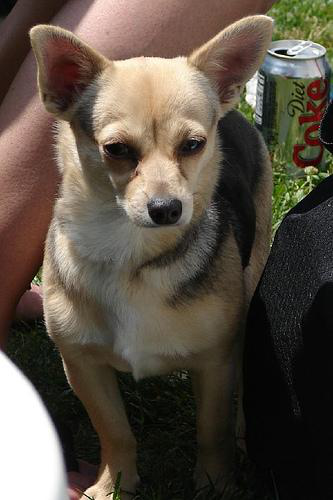

In [7]:
chihuahuas = [img for img in classes_path[0].iterdir()]
Image.open(chihuahuas[0])

Cargamos en *f* las rutas de todas las imagenes

In [8]:
labels = [str(c.stem) for c in sorted(imgs_path.glob('*'))]
f = sorted(imgs_path.glob('*/*'))
f[:5]

[PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_10074.jpg'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_10131.jpg'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_10621.jpg'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_1073.jpg'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02085620-Chihuahua/n02085620_10976.jpg')]

Hay una imagen que no sabemos porque figura tener cuatro canales: .shape = [4, H, W] asi que la eliminamos del dataset.

El codigo queda comentado porq cargar todas las imagenes en memoria consume demasiada RAM. Solo en necesario correr el bloque una vez.

In [9]:
# HAY UNA IMAGEN QUE VIENE CON 4 CANALES Y ROMPE TODO. CON ESTA CELDA SE ELIMINA PARA PODER ENTRENAR BIEN.


# imgs = [read_image(str(img)).to(device) for img in f]
# for i, img in enumerate(imgs):
#  if img.shape[0] == 4:
#    print(img.shape)
#    print('La encontre!', i)
#    print(f'Eliminando: {f[i]}')
#    f[i].unlink()

Creamos una clase que nos permita cargar las imagenes y pasarselas a pytorch segun su documentación.

In [10]:
class CustomImageDataset(Dataset):
  def __init__(self, imgs_dir, transform=None):
    self.imgs_dir = Path(imgs_dir)
    self.transform = transform
    self.f = sorted(imgs_path.glob('*/*'))
    self.labels = [str(c.stem) for c in sorted(imgs_path.glob('*'))]
    self.le = preprocessing.LabelEncoder()
    self.le.fit(self.labels)

  def __len__(self):
    return len(self.f)

  def __getitem__(self, idx):
    image = read_image(str(self.f[idx]))
    label = str(self.f[idx].parents[0].stem).split('/')[-1]
    if self.transform:
      image = self.transform(image)
    return image, int(self.le.transform([label]))

Como todas las imagenes tiene un aspect ration distinto, las transformamos para que todas tengan el mismo tamaño (256 x 256) y cargamos los datos usando *CustomImageDataset* y pasandole las transformaciones que definimos antes.

In [28]:
t = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

data = CustomImageDataset(f'{root_path}/images/Images', transform=t)

Al igual que con sklearn, hacemos un split para partir el dataset en train y test

In [29]:
from torch.utils.data import random_split

train, test = random_split(data, [round(len(data)*.6), round(len(data)*.4)], generator=torch.Generator().manual_seed(42))

Definimos nuestros Dataloaders que son los que va a usar el modelo para iterar en batches. Definimos el batch size en 128.

In [30]:
bs = 128

train_dataloader = DataLoader(train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
test_dataloader = DataLoader(test, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

Hacemos una iteracion de prueba sobre el train dataloader para verificar que podemos ver las imagenes y recibimos bien las labels.

In [31]:
%time train_features, train_labels = next(iter(train_dataloader))

CPU times: user 2.13 s, sys: 1.03 s, total: 3.16 s
Wall time: 6.11 s


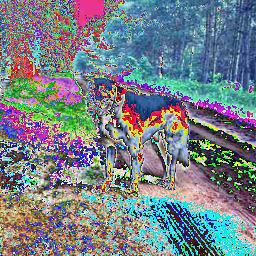

In [32]:
trans = transforms.ToPILImage()
trans(train_features[0])

In [34]:
print(f"Label: {train_labels[0]}")

Label: 71


## El modelo

Definimos nuestro modelo segun la documentacion de pytorch


(Si vemos el summary, de primera Linear layer pasa de 59536 neuronas a 120, tal vez conviene agregar una layer intermedia que baje la cant a un numero mas chico antes de pasar a 120. Pero lo vere cuando la gpu esté funcionando porque sino va a tardar mucho)

In [35]:
n_classes = 120

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # ho = 252
        self.pool = nn.MaxPool2d(2, 2)
        # ho, wo = 126
        self.conv2 = nn.Conv2d(6, 16, 5)
        # ho, wo = 122
        # MaxPool
        # ho, wo = 61
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()
model = model.to(device, non_blocking=True)

Definimos nuestra funcion de perdida como Cross Entropy Loss y nuestro optimizador SGD

In [36]:
params = [p for p in model.parameters() if p.requires_grad]
loss_f = nn.CrossEntropyLoss()
optimizer = optim.SGD(params, lr=0.005, momentum=0.9)
optimizer.zero_grad()

Definimos la funcion que calcula el accuracy

In [37]:
def calc_accuracy(outputs, y):
  _, predicted = torch.max(outputs.data, 1)
  correct = (predicted == y).sum().item()
  return tensor(correct / y.shape[0])

Definimos alguna funciones auxiliares para entrenar el modelo.

In [38]:
def calc_grad(xb, yb, model, loss_f):
    preds = model(xb)
    loss = loss_f(preds, yb)
    loss.backward()

In [39]:
def train_epoch(model, dl, trans=None, optimizer=None, loss_f=None):
    for xb,yb in dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device)
        if trans:
          xb = trans(xb)
        calc_grad(xb, yb, model, loss_f)
        optimizer.step()
        optimizer.zero_grad()

In [40]:
def validate_epoch(model, test_dl):
    accs = [calc_accuracy(model(xb.to(device, non_blocking=True)), yb.to(device)) for xb, yb in test_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [41]:
def train_model(model, epochs, dl, test_dl, transforms=None, optimizer=None, loss_f=None):
    for i in range(epochs):
        train_epoch(model, dl, transforms, optimizer, loss_f)
        print(f'{i+1} - Accuracy: {validate_epoch(model, test_dl)}')

Entrenamos el modelo.

In [42]:
%time train_model(model, 6, train_dataloader, test_dataloader, None, optimizer, loss_f)

1 - Accuracy: 0.0174
2 - Accuracy: 0.024
3 - Accuracy: 0.0338
4 - Accuracy: 0.0408
5 - Accuracy: 0.0455
6 - Accuracy: 0.0472
CPU times: user 1min 25s, sys: 30.4 s, total: 1min 55s
Wall time: 17min 5s


In [43]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install pip install nbdev &> 2

In [44]:
from fastai.vision.all import *

In [45]:
path = Path(f'{root_path}/images/Images')

In [46]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.4, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

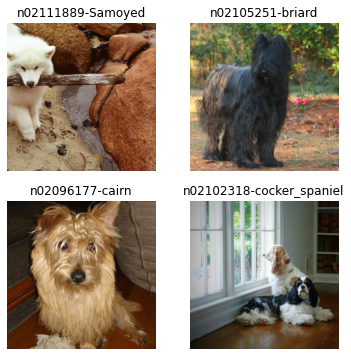

In [47]:
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4)

In [48]:
learn = Learner(dls, model, metrics=accuracy).to_fp16()

In [49]:
learn.fit(6, lr=0.002)

epoch,train_loss,valid_loss,accuracy,time
0,4.562868,4.453988,0.035354,03:15
1,4.374670,4.371966,0.041915,03:12
2,4.264887,4.282493,0.050784,03:13
3,4.193479,4.268378,0.052485,03:14
4,4.081340,4.349370,0.055886,03:16
5,3.996624,4.230547,0.067185,03:14


## Transfer Learning

In [51]:
from torchvision.models import alexnet
from torch.optim import lr_scheduler
import copy

alexnet = alexnet(pretrained=True)

for param in alexnet.parameters():
    param.requires_grad = False

In [52]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [53]:
alexnet.classifier[-1], alexnet.classifier[-1].in_features 

(Linear(in_features=4096, out_features=1000, bias=True), 4096)

In [54]:
num_ftrs = alexnet.classifier[-1].in_features

alexnet.classifier[-1] = nn.Linear(num_ftrs, 120)

alexnet = alexnet.to(device)

In [55]:
optimizer_ft = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [58]:
def train_model_pre(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [59]:
dataloaders_dict = {'train': train_dataloader, 'val': test_dataloader}

In [60]:
train_model(alexnet, dataloaders_dict, loss_f, optimizer_ft, num_epochs=4)

Epoch 0/3
----------
train Loss: 3.1117 Acc: 0.3132
val Loss: 1.9678 Acc: 0.5449

Epoch 1/3
----------
train Loss: 1.7092 Acc: 0.5676
val Loss: 1.5853 Acc: 0.6024

Epoch 2/3
----------
train Loss: 1.4124 Acc: 0.6297
val Loss: 1.4394 Acc: 0.6259

Epoch 3/3
----------
train Loss: 1.2457 Acc: 0.6692
val Loss: 1.3647 Acc: 0.6340

Training complete in 11m 32s
Best val Acc: 0.633989


(AlexNet(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace=True)
     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=9216, out_feature

In [50]:
# learn = cnn_learner(dls, alexnet, metrics=accuracy).to_fp16()

# lr = 3e-3
# learn.fine_tune(4, lr)